# [How I made top 0.3% on a Kaggle competition](https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition)

In [1]:
import os
os.chdir('/content/drive/MyDrive/kaggle/HousePrice')

In [2]:
# !unzip -qq "/content/drive/MyDrive/kaggle/HousePrice/HousePriceRegression.zip"  # 압축 해제

경쟁이 치열한 데이터 과학을 시작하는 것은 자신이 없을 수 있다. 그래서 필자는 Advanced Regression Techniques 대회에서 어떻게 상위 0.3%를 차지했는지에 대한 간략한 개요를 작성했다. 관심이 있다면, 이 커널에 사용된 feature engineering과 모델에 대한 직관을 깊이 들여다 볼 수 있다면 기쁘겠다.  

## 1.목표

* 데이터 셋의 각 행은 집의 특성을 나타낸다.
* 우리의 목표는 주어진 변수로 SalePrice를 예측하는 것이다. 
* 우리 모델은 우리 모델이 예측한 SalePrice 로그와 실제 로그 사이의 RMSE(Root Mean Square Error)로 평가된다. RMSE 오류를 로그 척도로 변환하면 비싼 주택과 저렴한 주택을 예측하는 오류가 동등하게 우리의 점수에 영향을 미칠 수 있다. 

## 2.이번 커널에서 교육(train) 프로세스의 주요 기능
  
* **Cross Validation**  : using 12-fold cross validation
* **Models** : 교차 검증 실행 마다 7개 모델에 적합.  
    (ridge, svr, gradient boosting, random forest, xgboost, lightgbm regressor)
* **stacking** : xgboost를 사용해 최적화된 메타 StackinfCVRegressor 훈련.
* **Blending** : 훈련된 모든 모델들은 다양한 각도로 과적합된다. 그러므로 최종 예측으로 만들기위해 예측들을 혼합.

## 3.모델 성능

아래 그래프에서 혼합 모델(Blended Mdoel)이 0.075의 RMSLE로 다른 모델을 훨씬 능가한다는 것을 알 수 있다. (작성자가 사용한 모델)

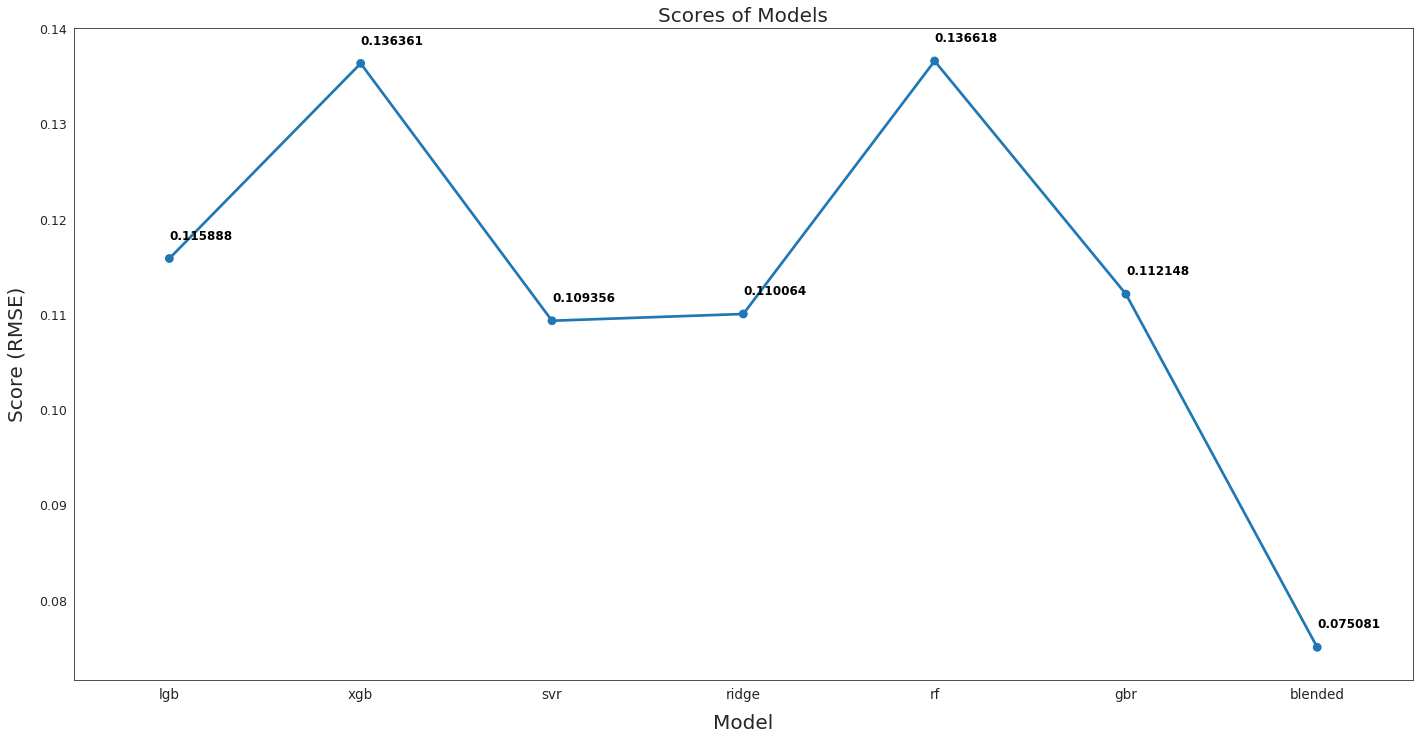

**맥락을 짚었으니 시작해보자**

In [3]:
# 필수
import numpy as np
import pandas as pd
import datetime 
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Mdoels
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns',None)

# Ignore useless warnings
import warnings 
warnings.filterwarnings(action='ignore')
pd.options.display.max_seq_items=8000
pd.options.display.max_rows=8000

In [4]:
# Read in the dataset as a dataFrame
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

## 4.EDA


### 1)목표

* 데이터 셋의 각 행은 집 값의 특징을 나타낸다. 
* 우리의 목표는 주어진 변수들로 SalePrice를 예측하는 것이다. 

In [5]:
# Preview the data wr're working with
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 2)SalePrice : 우리가 예측하려는 변수

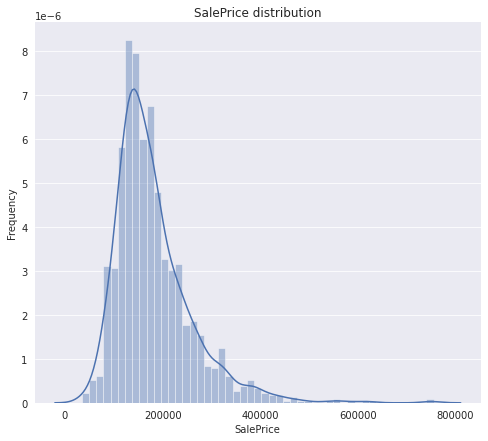

In [6]:
sns.set_style("darkgrid")
sns.set_color_codes(palette='deep')
f,ax=plt.subplots(figsize=(8,7))
# Check the new distribution
sns.distplot(train['SalePrice'],color='b')
ax.xaxis.grid(False)
ax.set(ylabel='Frequency')
ax.set(xlabel='SalePrice')
ax.set(title='SalePrice distribution')
sns.despine(trim=True, left=True)
plt.show()

In [7]:
# Skew and kurt
print(f"Skewness : {train['SalePrice'].skew():.8f}")
print(f"Kurtosis : {train['SalePrice'].kurt():.8f}")

Skewness : 1.88287576
Kurtosis : 6.53628186


### 3)Features : a deep dive

데이터 셋의 몇몇 변수 시각화 해보자

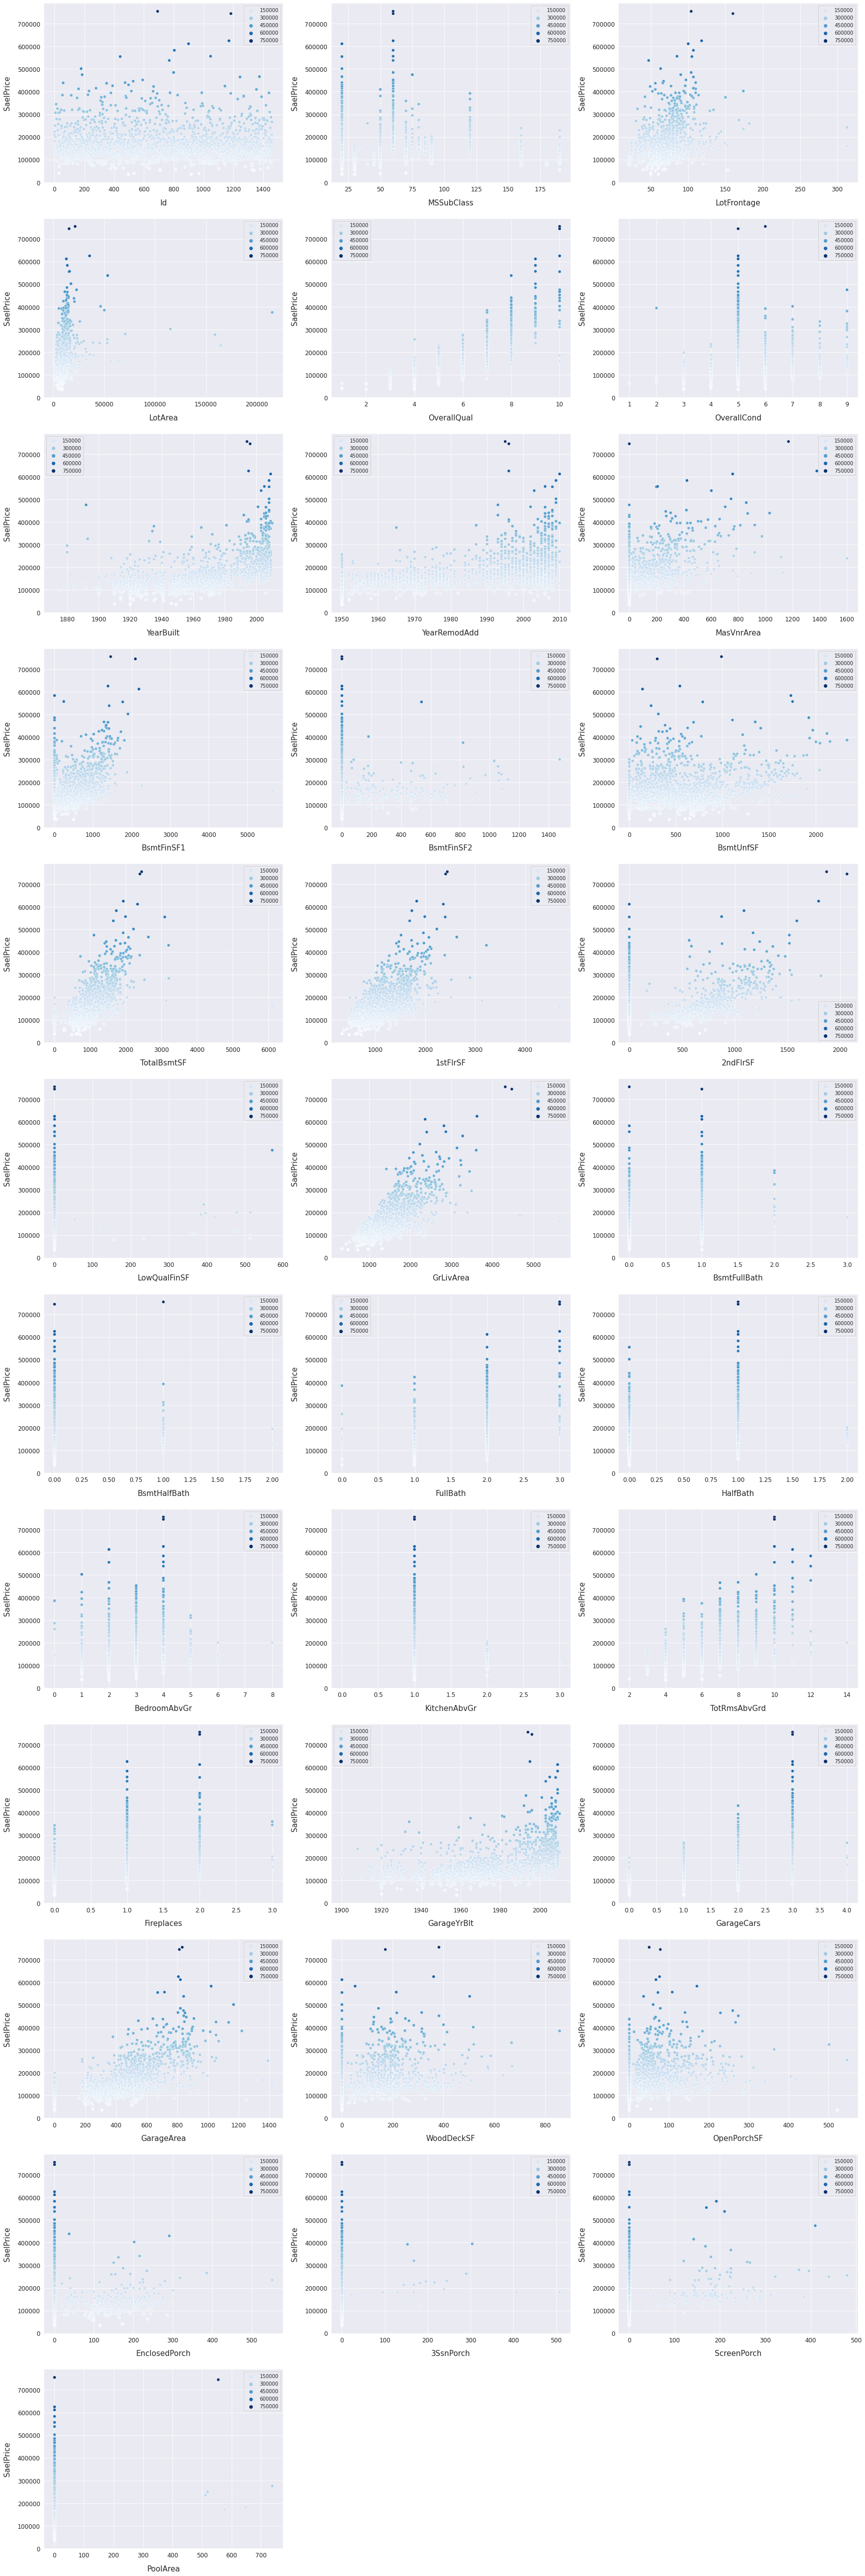

In [8]:
# Finding numeric feature
numeric_dtypes=['int16','int32','int64','float16','float32','float64']
numeric=[]
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
        if i in ['TotalSF','Total_Bathrooms','Ttal_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric.append(i)


# visualising some more outliers in the data values
fia,axs=plt.subplots(ncols=2, nrows=0,figsize=(12,120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette('husl',8)

for i, feature in enumerate(list(train[numeric]),1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric)),3,i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues',data=train)

    plt.xlabel('{}'.format(feature), size=15, labelpad=12.5)
    plt.ylabel('SaelPrice', size=15, labelpad=12.5)

    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size':10})

plt.show()


기능 간의 상관 관계 및 SalePrcie를 표시한다.

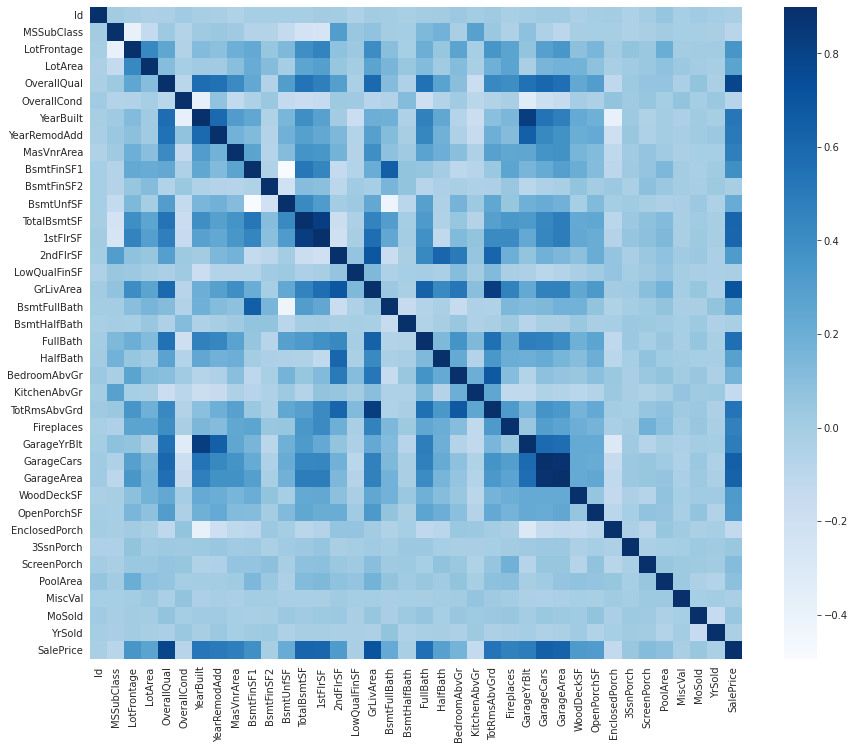

In [9]:
corr=train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap='Blues', square=True)

SalePrice와 데이터 세트의 일부 기능 간의 관계를 그림으로 표시한다. 

(-0.5, 9.5, 0.0, 800000.0)

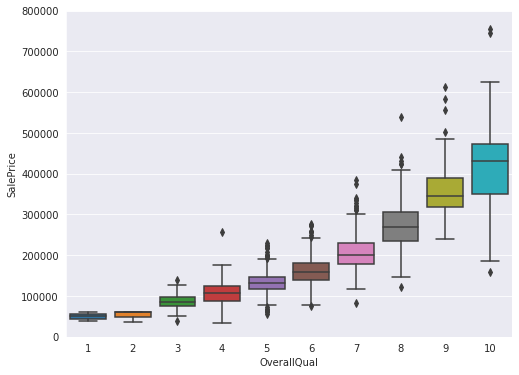

In [10]:
data=pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f,ax=plt.subplots(figsize=(8,6))
fig=sns.boxplot(x=train['OverallQual'], y='SalePrice', data=data)
fig.axis(ymin=0,ymax=800000)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text major ticklabel objects>)

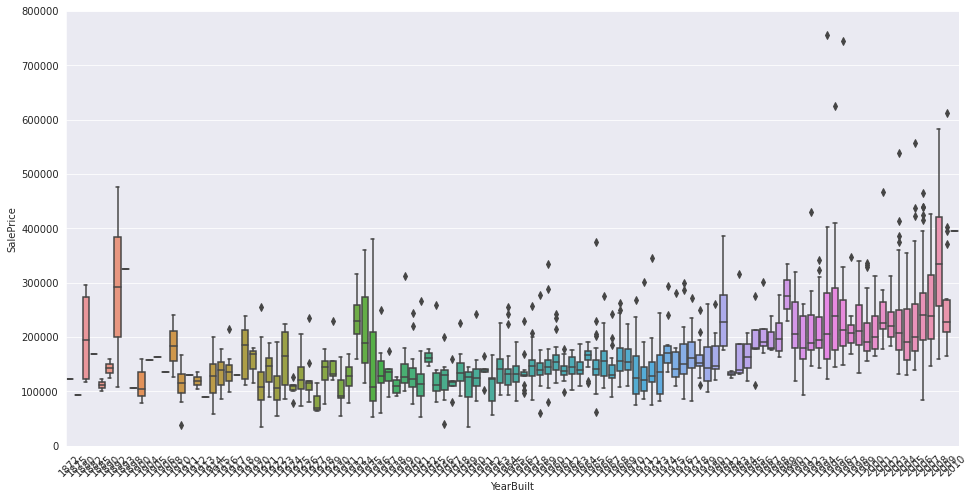

In [11]:
data=pd.concat([train['SalePrice'], train['YearBuilt']], axis=1)
f,ax=plt.subplots(figsize=(16,8))
fig=sns.boxplot(x=train['YearBuilt'], y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=45)

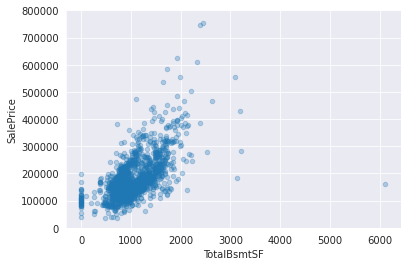

In [12]:
data=pd.concat([train['SalePrice'], train['TotalBsmtSF']],axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', alpha=0.3, ylim=(0,800000))

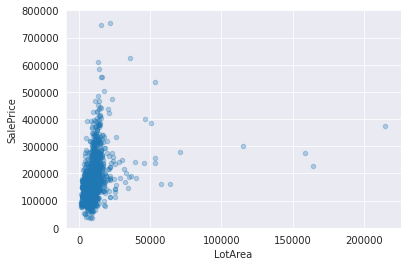

In [13]:
data=pd.concat([train['SalePrice'], train['LotArea']],axis=1)
data.plot.scatter(x='LotArea',y='SalePrice',alpha=0.3,ylim=(0,800000))

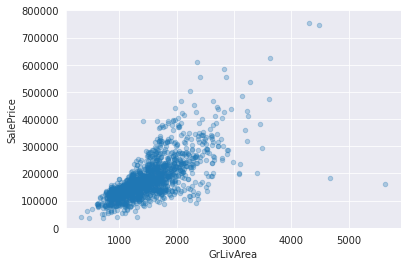

In [14]:
data=pd.concat([train['SalePrice'],train['GrLivArea']],axis=1)
data.plot.scatter(x='GrLivArea',y='SalePrice',alpha=0.3,ylim=(0,800000))

In [15]:
# Remove the Ids from train and test, as they are unique for each row and hence not useful for the model
train_ID=train['Id']
test_iD=test['Id']

train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

train.shape, test.shape

((1460, 80), (1459, 79))

## 5.Feature Engineering

SalePrice의 분포를 확인해보자.

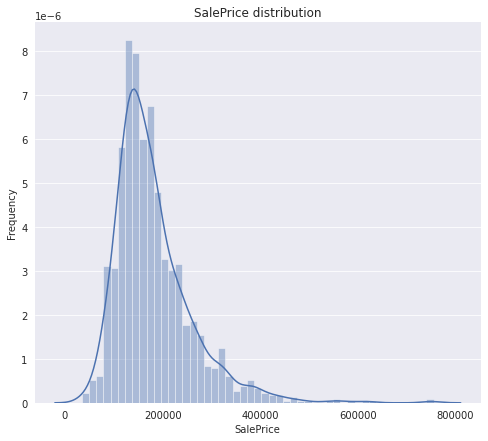

In [16]:
sns.set_style('darkgrid')
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8,7))

# Check the new distribution
sns.distplot(train['SalePrice'], color='b')
ax.xaxis.grid(False)
ax.set(ylabel='Frequency')
ax.set(xlabel='SalePrice')
ax.set(title='SalePrice distribution')
sns.despine(trim=True, left=True)
plt.show()

SalePrice는 오른쪽으로 치우쳐져있다. 이것은 대부분의 ML모형이 비정규 분포 데이터에 적합하지 않기 때문에 발생하는 문제이다. 왜곡을 수정하기 위해 log(1+x) 변환을 적용할 수 있다. 

In [17]:
# log(1+x) transform
train['SalePrice']=np.log1p(train['SalePrice'])

SalePrice를 다시 그려보자

(12.024015155682552, 0.3995757283645756)


 mu = 12.02 and sigma = 0.40


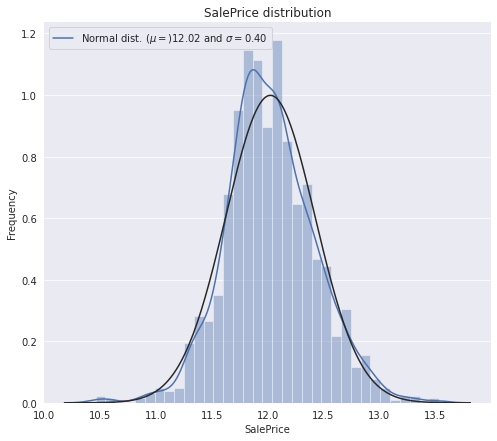

In [18]:
sns.set_style('darkgrid')
sns.set_color_codes(palette='deep')
f,ax=plt.subplots(figsize=(8,7))

# Check the new distribution
sns.distplot(train['SalePrice'], fit=norm, color='b')

# Get the fitted parameters used by the function
# 함수에 사용하기 적합한 매개변수 가져오기

(mu, sigma)=norm.fit(train['SalePrice'])
print( f"\n mu = {mu:.2f} and sigma = {sigma:.2f}")

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$){:.2f} and $\sigma=${:.2f}'.format(mu,sigma)],loc='best')
ax.xaxis.grid(False)
ax.set(ylabel='Frequency')
ax.set(xlabel='SalePrice')
ax.set(title='SalePrice distribution')
sns.despine(trim=True, left=True)

plt.show()

SalePrice는 정규 분포이다.

In [19]:
# 이상치 제거
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index,inplace=True)
train.drop(train[(train['GrLivArea']>4500)&(train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

### train/test 데이터 병합

In [22]:
# Split feature and labels
train_labels=train['SalePrice'].reset_index(drop=True)
train_features=train.drop(['SalePrice'],axis=1)
test_features=test

# Combine train and test features in order to apply the feature transformation pipline to the entire dataset
# 전체 데이터 세트 feature trasnform 파이프 라인을 적용하기 위해 train, test 변수 결합
all_features=pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2917, 79)

## 6.결측치 채우기

In [28]:
# determine the threshold for missing values
# 결측값에 대한 임계값 결정
def percent_missing(df):
    data=pd.DataFrame(df)
    df_cols=list(pd.DataFrame(data))
    dict_x={}
    for i in range(0,len(df_cols)):
        dict_x.update({df_cols[i]:round(data[df_cols[i]].isna().mean()*100,2)})
    
    return dict_x

missing=percent_missing(all_features)
df_miss=sorted(missing.items(), key=lambda x:x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

{'MSSubClass': 0.0, 'MSZoning': 0.14, 'LotFrontage': 16.66, 'LotArea': 0.0, 'Street': 0.0, 'Alley': 93.21, 'LotShape': 0.0, 'LandContour': 0.0, 'Utilities': 0.07, 'LotConfig': 0.0, 'LandSlope': 0.0, 'Neighborhood': 0.0, 'Condition1': 0.0, 'Condition2': 0.0, 'BldgType': 0.0, 'HouseStyle': 0.0, 'OverallQual': 0.0, 'OverallCond': 0.0, 'YearBuilt': 0.0, 'YearRemodAdd': 0.0, 'RoofStyle': 0.0, 'RoofMatl': 0.0, 'Exterior1st': 0.03, 'Exterior2nd': 0.03, 'MasVnrType': 0.82, 'MasVnrArea': 0.79, 'ExterQual': 0.0, 'ExterCond': 0.0, 'Foundation': 0.0, 'BsmtQual': 2.78, 'BsmtCond': 2.81, 'BsmtExposure': 2.81, 'BsmtFinType1': 2.71, 'BsmtFinSF1': 0.03, 'BsmtFinType2': 2.74, 'BsmtFinSF2': 0.03, 'BsmtUnfSF': 0.03, 'TotalBsmtSF': 0.03, 'Heating': 0.0, 'HeatingQC': 0.0, 'CentralAir': 0.0, 'Electrical': 0.03, '1stFlrSF': 0.0, '2ndFlrSF': 0.0, 'LowQualFinSF': 0.0, 'GrLivArea': 0.0, 'BsmtFullBath': 0.07, 'BsmtHalfBath': 0.07, 'FullBath': 0.0, 'HalfBath': 0.0, 'BedroomAbvGr': 0.0, 'KitchenAbvGr': 0.0, 'Kitche

[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.43),
 ('FireplaceQu', 48.68),
 ('LotFrontage', 16.66),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45),
 ('GarageCond', 5.45)]

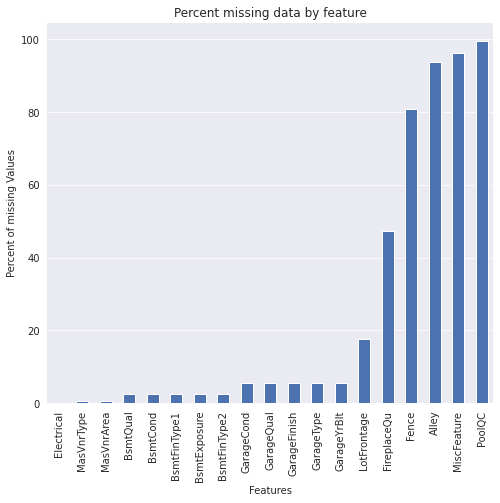

In [22]:
# 결측값 시각화
sns.set_style('darkgrid')
f,ax=plt.subplots(figsize=(8,7))
sns.set_color_codes(palette='deep')

missing=round(train.isnull().mean()*100,2)
missing=missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar(color='b')

# visual presentation 조정
ax.xaxis.grid(False)
ax.set(ylabel='Percent of missing Values')
ax.set(xlabel='Features')
ax.set(title='Percent missing data by feature')
sns.despine(trim=True, left=True)


이제 위의 각 기능을 살펴보고 각 기능에 대한 결측값을 대치할 수 있다. 

In [23]:
# 숫자가 아닌 예측 변수 중 일부는 숫자로 저장된다.(문자열로 변환)
all_features['MSSubClass']=all_features['MSSubClass'].apply(str)
all_features['YrSold']=all_features['YrSold'].astype(str)
all_features['MoSold']=all_features['MoSold'].astype(str)

In [24]:
def handle_missing(features):
    # 데이터 설명에 따르면 NA는 일반적인 ('Typ')값을 나타낸다.
    features['Functional'] = features['Functional'].fillna('Typ')
    # 아래 각 열의 누락된 값을 최빈값으로 대치 
    features['Electrical']=features['Electrical'].fillna('SBrkr')
    features['KitchenQual']=features['KitchenQual'].fillna('TA')
    features['Exterior1st']=features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd']=features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType']=features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

#     # NA로 설명된'No Pool'을 치환
    features['PoolQC']=features['PoolQC'].fillna('None')

    # 차고에 차가 없음 - 0으로 치환
    for col in ('GarageYrBlt','GarageArea','GarageCars'):
        features[col]=features[col].fillna(0)
    # 결측값을 None으로  대체
    for col in ['GarageType','GarageFinish','GarageQual','GarageCond']:
        features[col]=features[col].fillna('None')
    # 변주형 지하 변수에 대한 NaN값은 지하가 없음을 의미
    for col in ('BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'):
        features[col]=features[col].fillna('None')

    # 이웃을 기준으로 그룹화하고 이웃의 중앙값 LotFrontage로 결측값을 채운다.
    features['LotFrontage']=features.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

    # 나머지 범주형 변수를 채우는 방법에 대한 특별한 직관은 없다.
    # 그러니 나머지 결측치는 None로 채우자
    objects=[]
    for i in features.columns:
        if features[i].dtype==object:
            objects.append(i)
    features.update(features[objects].fillna('None'))

    # 나머지 수치형 변수 결측값은 0으로 대체
    numeric_dtypes=['int16','int32','int64','float16','float32','float64']
    numeric=[]
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))
    return features

all_features=handle_missing(all_features)

In [25]:
# 모든 결측치를 다뤘는지 확인해보자
missing=percent_missing(all_features)
df_miss=sorted(missing.items(), key=lambda x:x[1], reverse=True)
print('Precent of missing data')
df_miss[:10]

Precent of missing data


[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]

결측치 처리 완료.

## 7.변수 왜곡 수정(Fix skewed features)

In [26]:
numeric_dtypes=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric=[]
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

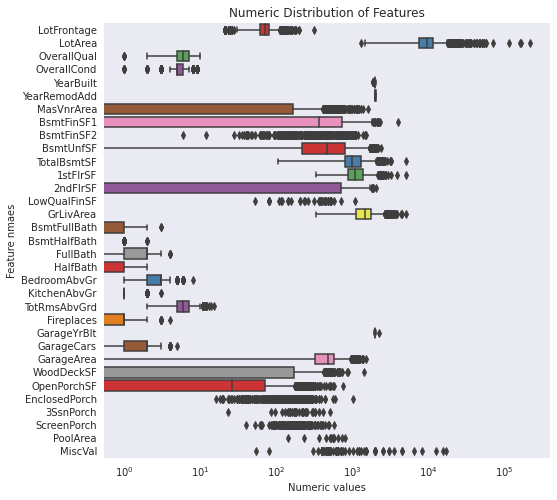

In [27]:
# 모든 수치형 변수에 대한 box plots 생성
sns.set_style('darkgrid')
f,ax=plt.subplots(figsize=(8,8))
ax.set_xscale("log")
ax=sns.boxplot(data=all_features[numeric], orient='h',palette='Set1')

ax.xaxis.grid(False)
ax.set(ylabel='Feature nmaes')
ax.set(xlabel='Numeric values')
ax.set(title='Numeric Distribution of Features')
sns.despine(trim=True, left=True)

In [28]:
# Find skewed numerical features
skew_features=all_features[numeric].apply(lambda x:skew(x)).sort_values(ascending=False)

high_skew=skew_features[skew_features>0.5]
skew_index=high_skew.index

print(f"There are {high_skew.shape[0]} numerical features with Skes > 0.5")
skewness=pd.DataFrame({'Skew':high_skew})
skew_features.head(10)

There are 25 numerical features with Skes > 0.5


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
dtype: float64

Box-Cox 변환을 계산하는 scipy 함수의 boxcox1p를 사용한다. 목표는 데이터를 정규화할 수 있는 간단한 변환을 찾는 것이다. 

In [29]:
# Noramlize skewed features
for i in skew_index:
    all_features[i]=boxcox1p(all_features[i], boxcox_normmax(all_features[i]+1))

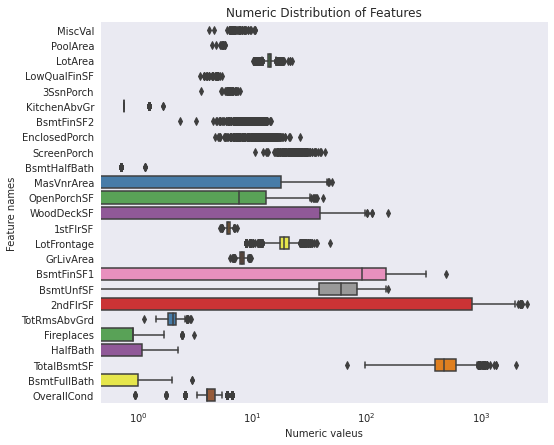

In [30]:
# 왜곡된 값을 조정했는지 확인해보자
sns.set_style('dark')
f,ax=plt.subplots(figsize=(8,7))
ax.set_xscale('log')
ax=sns.boxplot(data=all_features[skew_index],orient='h',palette='Set1')
ax.xaxis.grid(False)
ax.set(ylabel='Feature names')
ax.set(xlabel='Numeric valeus')
ax.set(title='Numeric Distribution of Features')
sns.despine(trim=True, left=True)

모든 변수들을 정규 분포를 보인다.

## 8.흥미로운 변수 생성

ML 모델은 더 복잡한 패턴을 인식하는데 어려움이 있으므로 (우리는 이 대회를 위해 신경망을 멀리한다.)데이터 세트에 대한 직관을 기반으로 각 집의 층, 욕실 및 현관 면적과 같은 몇 가지 변수를 만들어 모델을 돕자.

In [31]:
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
all_features = all_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])
all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['GarageCars'] = all_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
all_features['LotFrontage'] = all_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_features['MasVnrArea'] = all_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

### 1)Feature transformations

수치형 변수의 로그 및 제곱 변환을 계산해 더 많은 변수를 생성해보자. ML 모델은 log(feature) 또는 feature^2이 SalePrice의 예측 변수인지 확실하게 알 수 없기 때문에 수동으로 수행한다. 

In [32]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_features = logs(all_features, log_features)

In [33]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
all_features = squares(all_features, squared_features)

### 2)Encode categorical features

대부분의 모델은 숫자 피쳐만 처리할 수 있으므로 범주형 피처를 숫자로 인코딩한다.

In [34]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(2917, 379)

In [35]:
all_features.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,BsmtFinType1_Unf,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,YearsSinceRemodel,Total_Home_Quality,TotalSF,YrBltAndRemod,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,LotFrontage_log,LotArea_log,MasVnrArea_log,BsmtFinSF1_log,BsmtFinSF2_log,BsmtUnfSF_log,TotalBsmtSF_log,1stFlrSF_log,2ndFlrSF_log,LowQualFinSF_log,GrLivArea_log,BsmtFullBath_log,BsmtHalfBath_log,FullBath_log,HalfBath_log,BedroomAbvGr_log,KitchenAbvGr_log,TotRmsAbvGrd_log,Fireplaces_log,GarageCars_log,GarageArea_log,WoodDeckSF_log,OpenPorchSF_log,EnclosedPorch_log,3SsnPorch_log,ScreenPorch_log,PoolArea_log,MiscVal_log,YearRemodAdd_log,TotalSF_log,YearRemodAdd_sq,LotFrontage_log_sq,TotalBsmtSF_log_sq,1stFlrSF_log_sq,2ndFlrSF_log_sq,GrLivArea_log_sq,GarageCars_log_sq,GarageArea_log_sq,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po

In [37]:
# 중복된 columns명 제거
all_features=all_features.loc[:,~all_features.columns.duplicated()]

### 3)Recreate traning and test sets

In [42]:
X=all_features.iloc[:len(train_labels),:]
X_test=all_features.iloc[len(train_labels):,:]
X.shape, train_labels.shape, X_test.shape

((1458, 378), (1458,), (1459, 378))

모델을 훈련할 몇 가지 기능 시각화해본다.

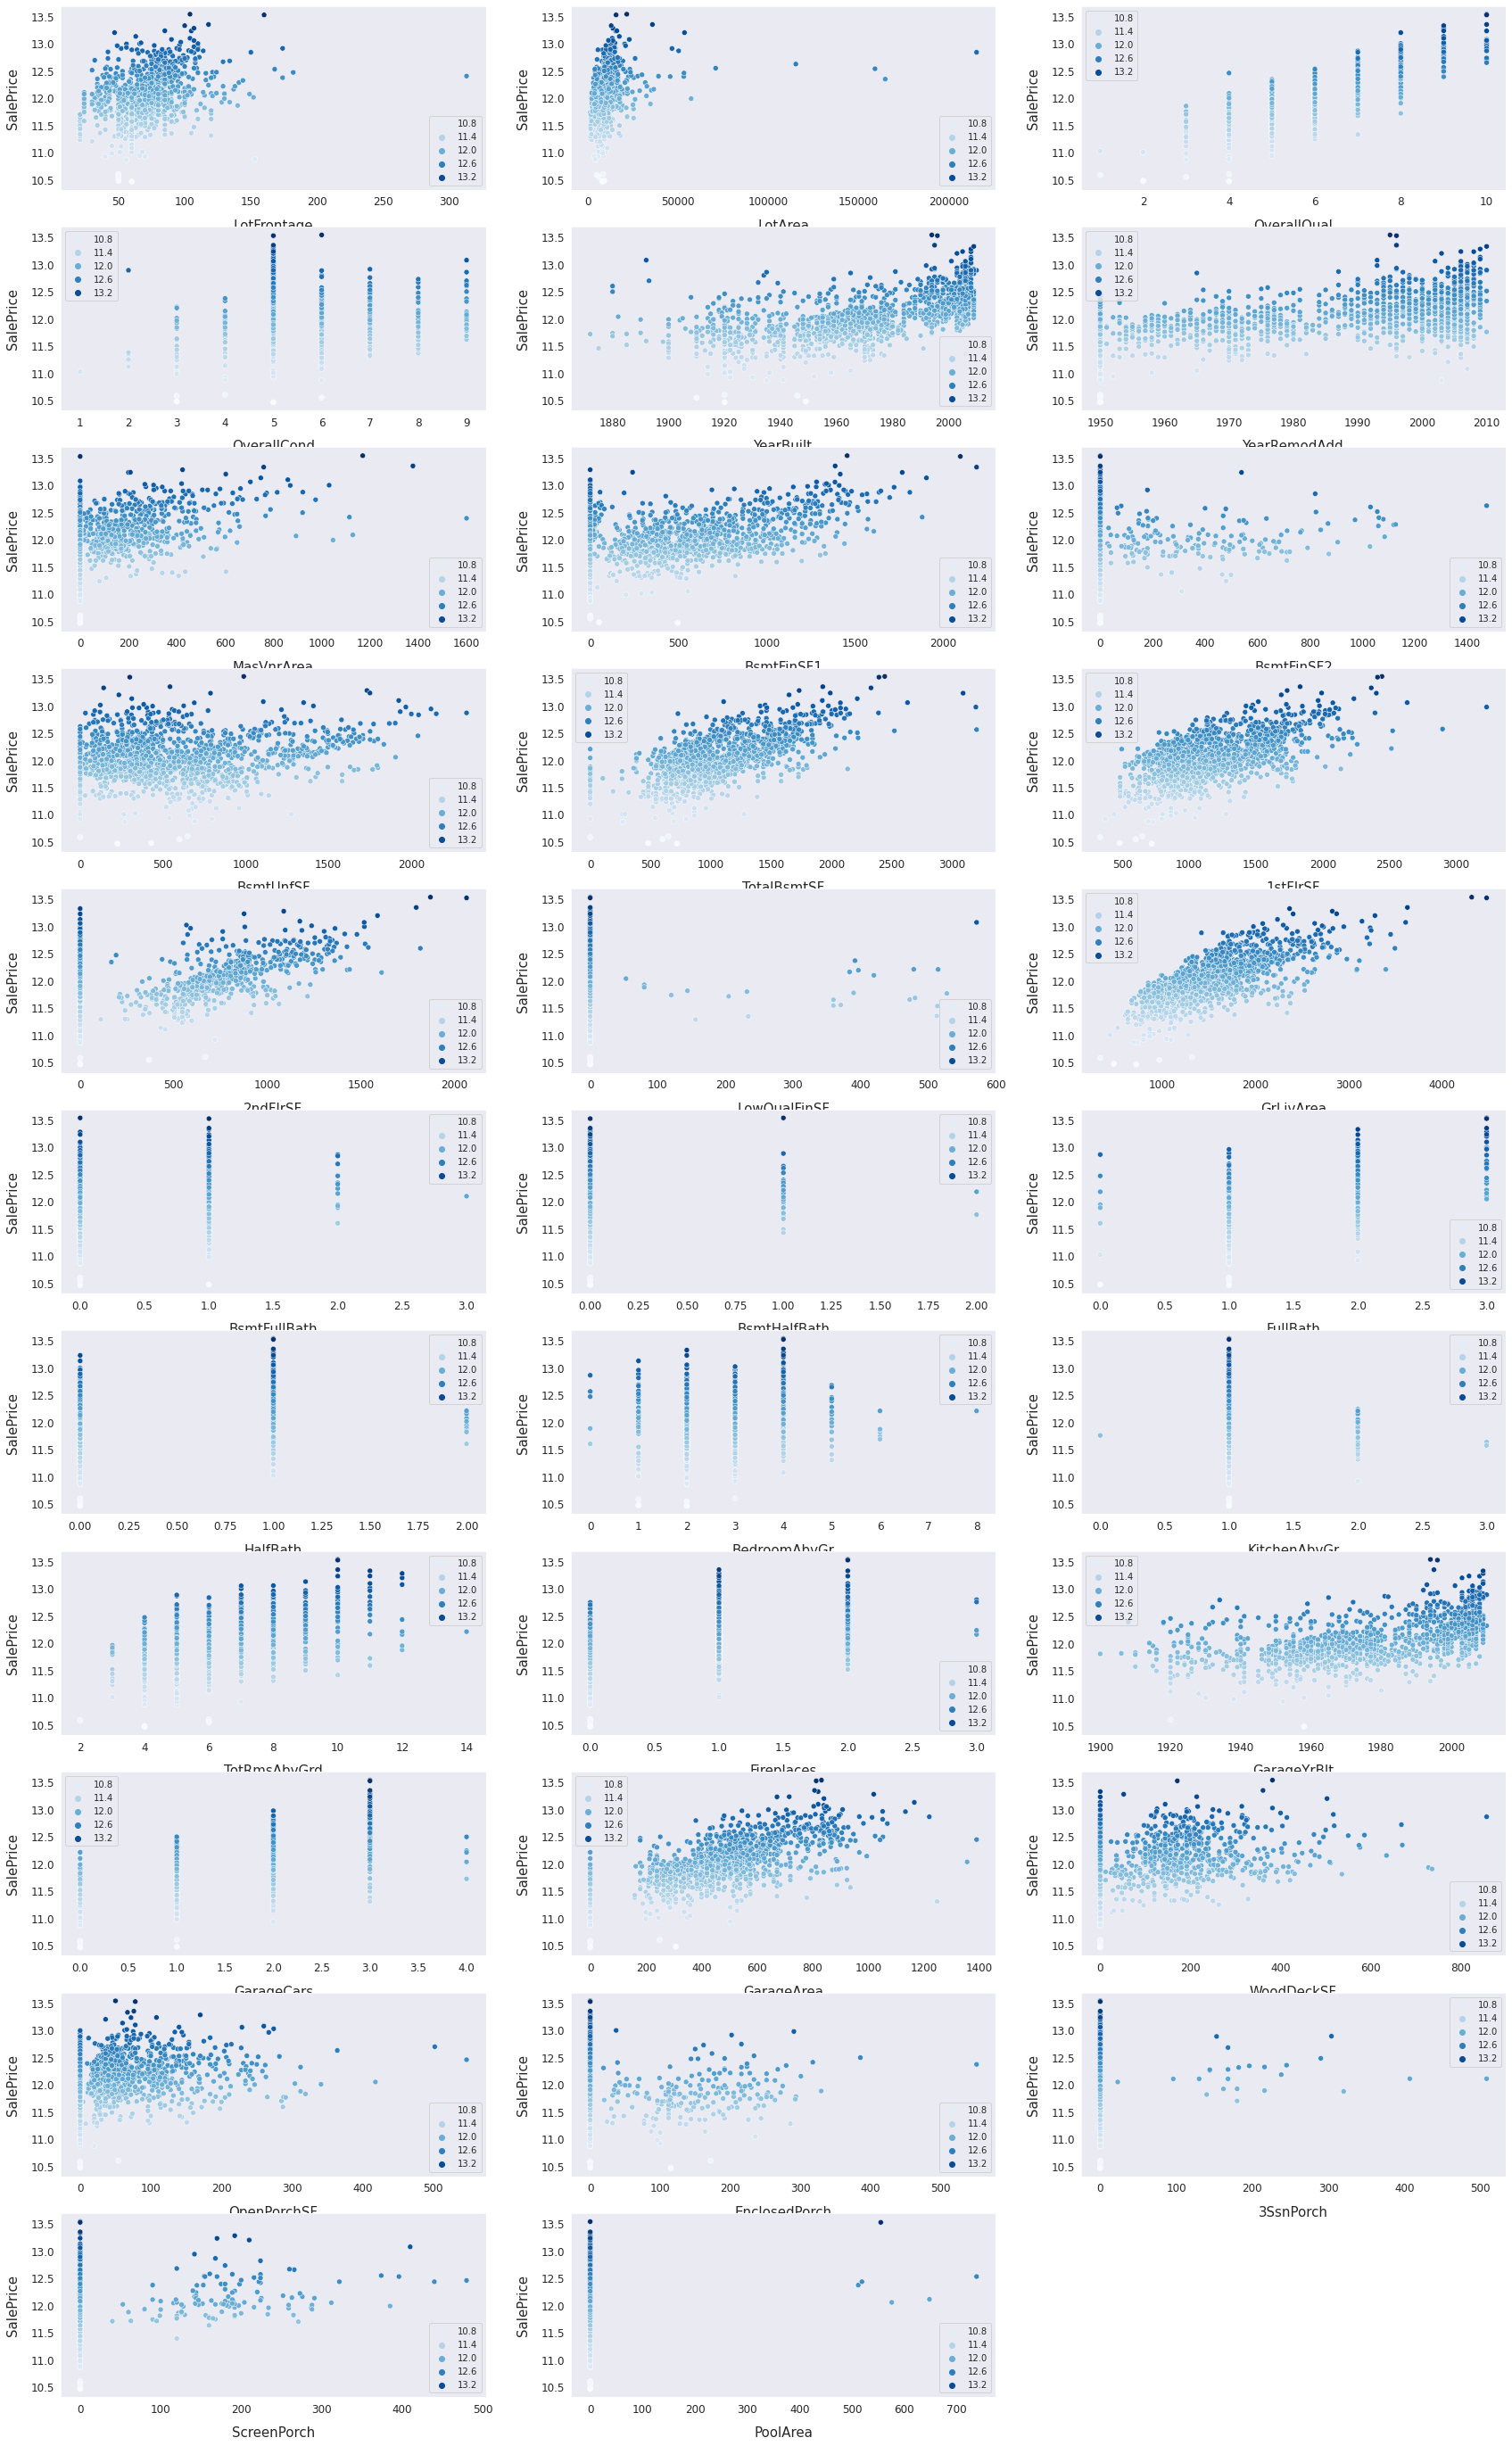

In [46]:
# Finding numeric features
numeric_dtypes=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric=[]
for i in X.columns:
    if X[i].dtype in numeric_dtypes:
        if i in ['TotalSF','Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric.append(i)

# 데이터 값의 일부 이상치 시각화
fig,axs=plt.subplots(ncols=2, nrows=0, figsize=(12,150))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette('husl',8)
for i, feature in enumerate(list(X[numeric]),1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric)),3,i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues',data=train)

    plt.xlabel('{}'.format(feature), size=15, labelpad=12.5)
    plt.ylabel('SalePrice', size=15,labelpad=12.5)

    for j in range(2):
        plt.tick_params(axis='x',labelsize=12)
        plt.tick_params(axis='y',labelsize=12)

    plt.legend(loc='best', prop={'size':10})

plt.show()

## 9.Train a model

### 1)모델 교육 프로세스의 주요 기능:
* **Cross Validation**- 12-fold cross_validation 사용
* **Models**- 교차검증 실행마다 7개 모델 적합 검증
* **Stacking**- xgboost를 사용해 최적화된 메타 StackingCVRegressor 훈련
* **Blending**- 모든 훈련된 모델은 다양한 각도로 과적합되어 있다. 그러므로 더 강력한 예측을 하는 최종 모델을 만들기 예측 혼합.



### 2)교차검증 설정 및 오류측정 항목 정의

In [49]:
# Setup cross validation folds
kf=KFold(n_splits=12, random_state=42, shuffle=True)

In [78]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

### 3)Setup models

In [119]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

### 4)Train models
모델별 교차 검증 실시

In [120]:
scores={}

score = cv_rmse(lightgbm)
print(f"lightgbm: {score.mean():.4f} ({score.std():.4f})")
scores['lgb']=(score.mean(), score.std())

lightgbm: 0.1164 (0.0169)


In [121]:
cv_rmse(xgboost)
print(f"xgboost:{score.mean():.4f} ({score.std():.4f})")
scores['xgb']=(score.mean(), score.std())

[05:18:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:19:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:20:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:21:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:23:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:24:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:25:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [122]:
score=cv_rmse(svr)
print(f"SVR : {score.mean():.4f} ({score.std():.4f})")
scores['svr']=(score.mean(), score.std())

SVR : 0.1094 (0.0200)


In [123]:
score=cv_rmse(ridge)
print(f"ridge : {score.mean():.4f} ({score.std():.4f})")
scores['ridge']=(score.mean(), score.std())

ridge : 0.1101 (0.0161)


In [124]:
score=cv_rmse(rf)
print(f"rf : {score.mean():.4f} ({score.std():.4f})")
scores['rf']=(score.mean(), score.std())

rf : 0.1366 (0.0188)


In [125]:
score=cv_rmse(gbr)
print(f"gbr :{score.mean():.4f} ({score.std():.4f})")
scores['gbr']=(score.mean(), score.std())

gbr :0.11214742305999288 (0.016553194141465655)


###5) Fit the models

In [126]:
print('stack_gen')
stack_gen_model=stack_gen.fit(np.array(X), np.array(train_labels))

stack_gen
[05:45:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:46:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:46:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:47:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [127]:
print('lightgbm')
lgb_model_full_data=lightgbm.fit(X, train_labels)

lightgbm


In [128]:
print('xgboost')
xgb_model_full_data=xgboost.fit(X, train_labels)

xgboost
[05:59:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [129]:
print('Svr')
svr_model_full_data=svr.fit(X, train_labels)

Svr


In [130]:
print('Ridge')
ridge_model_full_data=ridge.fit(X, train_labels)

Ridge


In [131]:
print('RandomForest')
rf_model_full_data=rf.fit(X, train_labels)

RandomForest


In [132]:
print('GradientBoosting')
gbr_model_full_data=gbr.fit(X, train_labels)

GradientBoosting


### 6) 모델 혼합 및 예측

In [133]:
# Blend models in order to make the final predictionsmore robust to overfitting
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X)) + \
            (0.2 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))

In [134]:
# Get final predictions from the blended model
blended_score=rmsle(train_labels, blended_predictions(X))
scores['blended']=(blended_score,0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.07540381447865116


### 6)최적의 수행 모델 식별

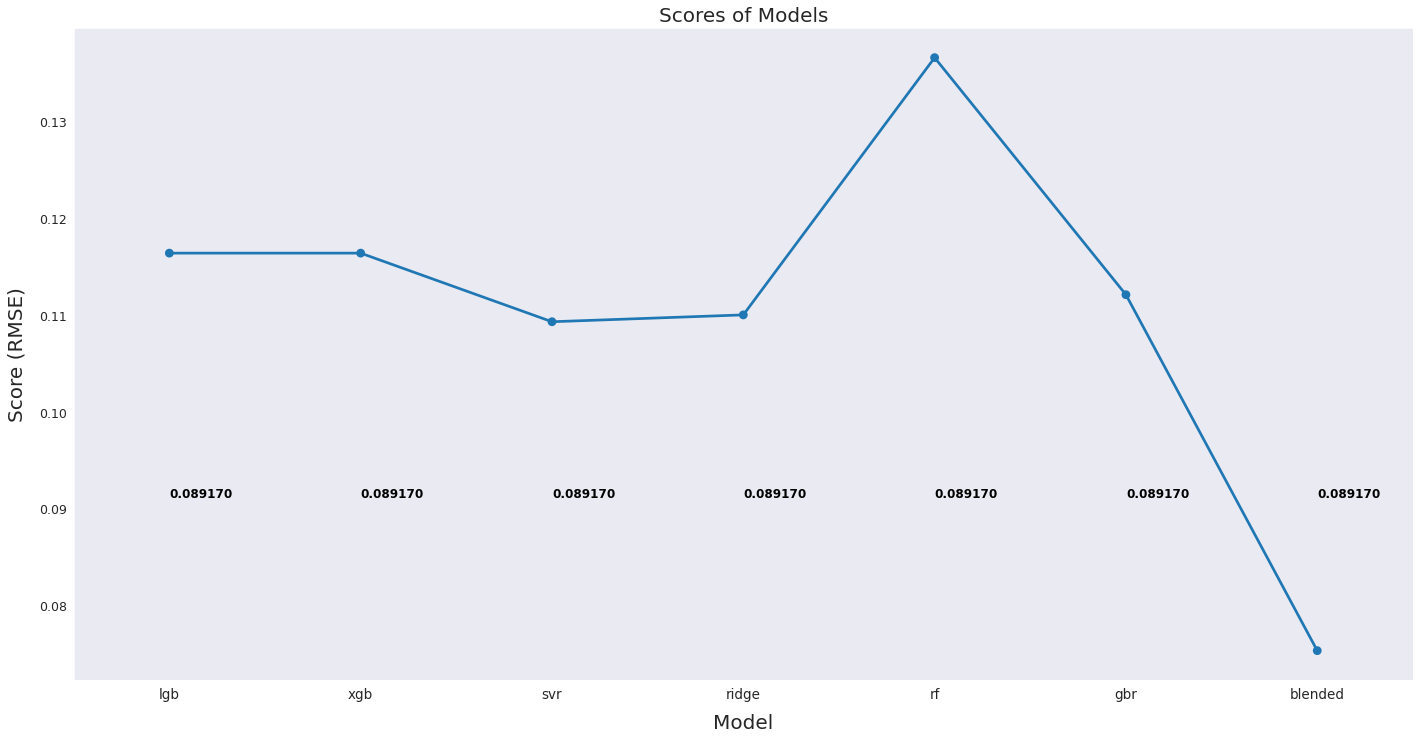

In [137]:
# Plot the predictions for each model
sns.set_style('dark')
fig=plt.figure(figsize=(24,12))

ax=sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, socre in enumerate(scores.values()):
    ax.text(i, score[0]+0.002,'{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black',weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

위 그래프에서 혼합 모델(Blended model)이 RMSLE 0.075로 다른 모델을 능가한다는 것을 알 수 있다. 그러므로 이를 최종 예측 모델로 사용할 것 이다. 

## 10.Submit predictions

In [141]:
# Read in sample_submisson dataframe
submission=pd.read_csv('sample_submission.csv')
submission.shape

(1459, 2)

In [148]:
# Append predcitions from blended models
submission.iloc[:,1]=np.floor(np.expm1(blended_predictions(X_test)))

In [154]:
# Fix outlier predictions
q1=submission['SalePrice'].quantile(0.0045)
q2=submission['SalePrice'].quantile(0.99)

submission['SalePrice']=submission['SalePrice'].apply(lambda x:x if x> q1 else x*0.66)
submission['SalePrice']=submission['SalePrice'].apply(lambda x:x if x < q2 else x*1.1)
# submission.to_csv('submission_regression1.csv',index=False)

In [ ]:
# Scale predictinos
# submission['SalePrice'] *= 1.001619
# submission.to_csv('submission_regression2.csv', index=False)